# Purpose:
The purpose of this notebook is to demo how to interact with the computational memory lab's subjects in both scalp and ieeg experiments. And to give the user a little bit more information regarding how to start an analysis(which is often the most difficult part)

Please use python2.7, please please please.

# Loading Subjects:
Loading subjects can be done one of two ways, either with their json file (older subjects in older experiments might not have these) through using JsonEventReader to read subject's information into BaseEventReader to make the events. Or just directly through BaseEventReader by referencing matlab paths of older subjects
#### Make sure you have installed ptsa (terminal command: conda install ptsa -c pennmem) 


In [135]:
# Import general useful packages
%matplotlib notebook
from matplotlib import pyplot as plt
import mne
import pandas as pd
import xarray as xr
import numpy as np
import os, sys
from glob import glob
# Import ptsa Readers
from ptsa.data.readers import BaseEventReader
from ptsa.data.readers.IndexReader import JsonIndexReader

# Using JsonIndexReader
This way is the prefered method of getting data from experiments due to it's ease in loading subjects, as well as having a more accurate reading of the exact time of events than BaseEventReader (JR uses a more accurate algorithm I will not go into here). 

####  Refer to wiki for more detailed explainations of how  events work
https://memory.psych.upenn.edu/InternalWiki/Events_Database_Documentation

In [2]:
# The structure is like this. I'll walk you through it.
# But this might be handy to reference later, it's referenced
# On the wiki (Plug for the wiki page here)
'''
{
 "protocols": {
   "r1": {
     "subjects": {
       "R1001P": {
         "experiments": {
           "FR1": {
             "sessions": {
               "0": {
                 "all_events": "protocols/r1/subjects/R1001P/experiments/FR1/sessions/0/behavioral/current_processed/all_events.json",
                 "contacts": "protocols/r1/subjects/R1001P/localizations/0/montages/0/neuroradiology/current_processed/contacts.json",
                 "import_type": "build",
                 "localization": "0",
                 "math_events": "protocols/r1/subjects/R1001P/experiments/FR1/sessions/0/behavioral/current_processed/math_events.json",
                 "montage": "0",
                 "original_session": 1,
                 "pairs": "protocols/r1/subjects/R1001P/localizations/0/montages/0/neuroradiology/current_processed/pairs.json",
                 "subject_alias": "R1001P",
                 "task_events": "protocols/r1/subjects/R1001P/experiments/FR1/sessions/0/behavioral/current_processed/task_events.json"
               }
             }
           },
           "FR2": {
             "sessions": {
               "0": {
                 "all_events": "protocols/r1/subjects/R1001P/experiments/FR2/sessions/0/behavioral/current_processed/all_events.json",
                 "contacts": "protocols/r1/subjects/R1001P/localizations/0/montages/0/neuroradiology/current_processed/contacts.json",
                 "import_type": "build",
                 "localization": "0",
                 "math_events": "protocols/r1/subjects/R1001P/experiments/FR2/sessions/0/behavioral/current_processed/math_events.json",
                 "montage": "0",
                 "original_session": 1,
                 "pairs": "protocols/r1/subjects/R1001P/localizations/0/montages/0/neuroradiology/current_processed/pairs.json",
                 "subject_alias": "R1001P",
                 "task_events": "protocols/r1/subjects/R1001P/experiments/FR2/sessions/0/behavioral/current_processed/task_events.json"
               }
             }
           },
'''

'\n{\n "protocols": {\n   "r1": {\n     "subjects": {\n       "R1001P": {\n         "experiments": {\n           "FR1": {\n             "sessions": {\n               "0": {\n                 "all_events": "protocols/r1/subjects/R1001P/experiments/FR1/sessions/0/behavioral/current_processed/all_events.json",\n                 "contacts": "protocols/r1/subjects/R1001P/localizations/0/montages/0/neuroradiology/current_processed/contacts.json",\n                 "import_type": "build",\n                 "localization": "0",\n                 "math_events": "protocols/r1/subjects/R1001P/experiments/FR1/sessions/0/behavioral/current_processed/math_events.json",\n                 "montage": "0",\n                 "original_session": 1,\n                 "pairs": "protocols/r1/subjects/R1001P/localizations/0/montages/0/neuroradiology/current_processed/pairs.json",\n                 "subject_alias": "R1001P",\n                 "task_events": "protocols/r1/subjects/R1001P/experiments/FR1/session

In [3]:
# This class allows for querying of aggregate information across subjects
# Experiment, etc.
from ptsa.data.readers.IndexReader import JsonIndexReader
jr = JsonIndexReader('/protocols/r1.json')

In [96]:
#experiments Json can get
jr.experiments()

[u'FR1',
 u'FR2',
 u'FR3',
 u'FR5',
 u'PAL1',
 u'PAL2',
 u'PAL3',
 u'PAL5',
 u'PS1',
 u'PS2',
 u'PS2.1',
 u'PS3',
 u'TH1',
 u'TH3',
 u'THR',
 u'THR1',
 u'YC1',
 u'YC2',
 u'catFR1',
 u'catFR2',
 u'catFR3',
 u'catFR5']

In [4]:
# Get the subj ids of the first ten subjects in FR1
f_subjs = jr.subjects(experiment='FR1')[:10]
print(f_subjs)

[u'R1001P', u'R1002P', u'R1003P', u'R1006P', u'R1010J', u'R1015J', u'R1018P', u'R1020J', u'R1022J', u'R1023J']


In [5]:
# Let's look at the 9th indexed subject 
subj = f_subjs[-1]
# Get experiments that the last subject is in
subj_exp = jr.experiments(subject=subj)
print(subj_exp)

[u'FR1', u'FR2', u'PAL1', u'YC1', u'YC2']


In [6]:
# Let's look at FR1 data
exp = subj_exp[0]
# How many sessions does the subj have?
sessions=jr.sessions(subject=subj,experiment=exp)
print('there are this many sessions for the subject:', str(sessions))

('there are this many sessions for the subject:', "[u'0']")


In [7]:
# Get electrodes for the subj
trodes = jr.montages(subject=subj, experiment=exp)
print(trodes)

[u'0']


In addition to the function subjects, experiments, montages, and sessions, there exist two general purpose methods for retrieving values: get_value() and aggregate_values(). get_value() will return a single value for the field that is passed in, or throw an error if multiple fields exist for the specified arguments. aggregate_values() will return any field, aggregated across the arguments provided. Examples of use are below:

In [8]:
# Using aggregate_values function
jr.aggregate_values('subject_alias', subject='R1092J')
set([u'R1092J_3', u'R1092J_2', u'R1092J_1', u'R1092J'])

{u'R1092J', u'R1092J_1', u'R1092J_2', u'R1092J_3'}

# Correct Usuage of get_value

In [9]:
jr.get_value('task_events', 
                 subject='R1092J', 
                 experiment='FR1', 
                 session=0)

'/protocols/r1/subjects/R1092J/experiments/FR1/sessions/0/behavioral/current_processed/task_events.json'

### Incorect usuage of get_value

In [10]:
jr.get_value('task_events', subject='R1092J', experiment='FR1')

ValueError: Expected 1 value for task_events, found 4

# Get the event files

In [11]:
events = np.concatenate([BaseEventReader(filename=f).read() for f in
                         jr.aggregate_values('task_events',
                                             subject=subj,
                                             experiment=exp)]
                        )
# Because np.concatenate turns record arrays into structured arrays, and attribute-like field access is nice
events = np.array(events).view(np.recarray)

In [13]:
events

rec.array([ (0,  362021, 'r1', -999, 'X', -999,  -999, [], -999, 'R1023J', '/protocols/r1/subjects/R1023J/experiments/FR1/sessions/0/ephys/current_processed/noreref/R1023J_FR1_0_27Feb15_1337', '0.0', 'FR1', 0,  0, 0, -999, 1425063028829, 0, 'SESS_START', '1.04'),
           (0,  376574, 'r1', -999, 'X', -999,  -999, [], -999, 'R1023J', '/protocols/r1/subjects/R1023J/experiments/FR1/sessions/0/ephys/current_processed/noreref/R1023J_FR1_0_27Feb15_1337', '0.0', 'FR1', 0,  0, 0, -999, 1425063043382, 0, 'COUNTDOWN_START', '1.04'),
           (0,  387001, 'r1', -999, 'X', -999,  -999, [], -999, 'R1023J', '/protocols/r1/subjects/R1023J/experiments/FR1/sessions/0/ephys/current_processed/noreref/R1023J_FR1_0_27Feb15_1337', '0.0', 'FR1', 0,  0, 0, -999, 1425063053810, 0, 'COUNTDOWN_END', '1.04'),
           (0,  390663, 'r1', -999, 'ATTIC',    0,  -999, [],   -1, 'R1023J', '/protocols/r1/subjects/R1023J/experiments/FR1/sessions/0/ephys/current_processed/noreref/R1023J_FR1_0_27Feb15_1337', '0.0',

# Oh God that looks so gross

In [45]:
# DataFrames look less gross
events_df = pd.DataFrame.from_records([event for event in events],
                                   columns = events.dtype.names)

events_df

,session,eegoffset,protocol,intrusion,item_name,serialpos,rectime,stim_params,list,subject,...,montage,experiment,recalled,msoffset,stim_list,item_num,mstime,is_stim,type,exp_version
0,0,362021,r1,-999,X,-999,-999,[],-999,R1023J,...,0.0,FR1,0,0,0,-999,1425063028829,0,SESS_START,1.04
1,0,376574,r1,-999,X,-999,-999,[],-999,R1023J,...,0.0,FR1,0,0,0,-999,1425063043382,0,COUNTDOWN_START,1.04
2,0,387001,r1,-999,X,-999,-999,[],-999,R1023J,...,0.0,FR1,0,0,0,-999,1425063053810,0,COUNTDOWN_END,1.04
3,0,390663,r1,-999,ATTIC,0,-999,[],-1,R1023J,...,0.0,FR1,0,1,0,-1,1425063057472,0,PRACTICE_WORD,1.04
4,0,393235,r1,-999,IRON,1,-999,[],-1,R1023J,...,0.0,FR1,0,1,0,-1,1425063060044,0,PRACTICE_WORD,1.04
5,0,395722,r1,-999,WATCH,2,-999,[],-1,R1023J,...,0.0,FR1,0,1,0,-1,1425063062531,0,PRACTICE_WORD,1.04
6,0,398244,r1,-999,TONGUE,3,-999,[],-1,R1023J,...,0.0,FR1,0,1,0,-1,1425063065053,0,PRACTICE_WORD,1.04
7,0,400730,r1,-999,RHINO,4,-999,[],-1,R1023J,...,0.0,FR1,0,1,0,-1,1425063067539,0,PRACTICE_WORD,1.04
8,0,403186,r1,-999,CAMEL,5,-999,[],-1,R1023J,...,0.0,FR1,0,1,0,-1,1425063069995,0,PRACTICE_WORD,1.04
9,0,405622,r1,-999,WAGON,6,-999,[],-1,R1023J,...,0.0,FR1,0,1,0,-1,1425063072431,0,PRACTICE_WORD,1.04


# Organize Json functions

In [14]:
def get_json_subjs(exp):
    """
    Get subject ids using jsonIndexReader
    
    -----
    INPUTS:
    exp: the name of the experiment get subjects for
    -----
    OUTPUTS:
    subjs: a list of subjects for the experiment
    """
    from ptsa.data.readers.IndexReader import JsonIndexReader
    jr = JsonIndexReader('/protocols/r1.json')
    subjs = jr.subjects(experiment=exp)
    return subjs

def get_json_info(subj):
    """
    Returns a dictionary of the number of sessions of data
    each subject has for a given experiment, as well as 
    the montage number per session (this may be the same value)
    ------
    INPUTS:
    subj: a string or unicode of a valid subject_id gotten
    ------
    OUTPUTS:
    exp_d: a dictionary of how many sessions a subject has per exp
    montages_d: a dictionary of the montage per exp.
    """
    from ptsa.data.readers.IndexReader import JsonIndexReader
    jr = JsonIndexReader('/protocols/r1.json')
    # Get a dictionary of how many sessions are in each exp 
    # the subj has
    exp_d = {exp: jr.sessions(subject=subj,experiment=exp
                         ) for exp in jr.experiments(subject=subj)}
    # Get electrode montage number for the subj per exp
    montages_d = {exp: jr.montages(subject=subj,experiment=exp
                     ) for exp in jr.experiments(subject=subj)}
    return exp_d, montages_d

def get_json_events(subj, exp, pandas=False):
    """
    loads subjects events using the json method and return out
    their behavioral events as pandas dataframe (pandas=True),
    numpy recarray (recarray=True) or both
    
    INPUTS:
    subj: a string or unicode of a valid subject_id 
    exp: the name of the experiment get subjects for
    ------
    OUTPUTS:
    events: np.recarray, behavioral events for subj
    events_df: pd.DataFrame, behavioral events for subj
    """
    from ptsa.data.readers.IndexReader import JsonIndexReader
    from ptsa.data.readers import BaseEventReader
    import numpy as np
    if pandas is True:
        import pandas as pd
    jr = JsonIndexReader('/protocols/r1.json')
    events = np.concatenate([BaseEventReader(filename=f).read() for f in
                             jr.aggregate_values('task_events',
                                                 subject=subj,
                                                 experiment=exp)]
                        )
    
    # Because np.concatenate turns record arrays into structured arrays, 
    # and attribute-like field access is nice
    events = np.array(events).view(np.recarray)
    if pandas is False:
        return events
    events_df = pd.DataFrame.from_records([event for event in events],
                                       columns = events.dtype.names)
    return events, events_df


# Loading Data without Json
#### Once again, the exact timing of signal based upon this events is off this way compared to the json, so this methods should exlusively be used when json isn't there, as two subject loaded the two different ways will have different mstime values, and the json's match is closer to being "correct"

In [54]:
# This is a very handy way of getting everything that matches this path
# Except for the wildcard which can be anything (e.g. all our subjects)
ev_files = glob('/data/events/pyFR/*_events.mat')
pyFRsubs = [d.split('/')[-1].split('_ev')[0] for d in ev_files]

In [55]:
pyFRsubs

['FR240',
 'CP001',
 'BW001',
 'FR025',
 'BW013',
 'FR029',
 'BW014',
 'FR060',
 'BW022',
 'BW023',
 'FR070',
 'BW024',
 'FR080',
 'BW025',
 'FR090',
 'CH003',
 'FR091',
 'CH005',
 'FR100',
 'CH008b',
 'FR110',
 'CH012',
 'FR120',
 'CH013',
 'FR130',
 'CH018',
 'FR140',
 'CH040',
 'FR150',
 'CH042',
 'FR160',
 'CH046',
 'FR170',
 'CH048',
 'FR180',
 'CH058',
 'FR190',
 'CH061',
 'FR200',
 'CH063',
 'CH065',
 'FR210',
 'CH066',
 'CH067',
 'FR220',
 'CH068',
 'FR032',
 'FR230',
 'FR037',
 'FR038',
 'FR050',
 'FR250',
 'FR260',
 'FR270',
 'FR280',
 'FR290',
 'FZ001',
 'FZ002',
 'FZ003',
 'FZ004',
 'FZ005',
 'FZ006',
 'FZ007',
 'FZ008',
 'FZ009',
 'TJ001',
 'TJ003',
 'TJ004',
 'TJ005_1',
 'TJ005',
 'TJ006',
 'TJ010',
 'TJ011',
 'TJ013',
 'TJ015',
 'TJ016',
 'TJ017',
 'TJ018_1',
 'TJ018_2',
 'TJ018',
 'TJ019',
 'TJ020',
 'TJ021',
 'TJ022',
 'TJ024',
 'TJ025',
 'TJ027',
 'TJ028',
 'TJ029',
 'TJ030',
 'TJ031',
 'TJ032',
 'TJ033',
 'TJ034',
 'TJ035_1',
 'TJ036',
 'TJ037',
 'TJ038_1',
 'TJ038',

In [86]:
# Let's get the events of a subject using the old way
exp= 'RAM_FR1'
subj='R1111M'

path = '/data/events/'+exp+'/'+subj+'_events.mat'
events = BaseEventReader(filename=path).read()
events = np.array(events).view(np.recarray)
events

rec.array([ (u'R1111M', 0, -999, -999, u'B', u'X', -999, -999,   1.45349914e+12, 0, -999, -999, -999, u'', u'X', -999., -999., '', -999., '', -999, u'/data/eeg/R1111M/eeg.noreref/R1111M_FR1_0_22Jan16_1638',   23092),
           (u'R1111M', 0, -999, -999, u'SESS_START', u'X', -999, -999,   1.45349914e+12, 0, -999, -999, -999, u'v_1.05', u'X', -999., -999., '', -999., '', -999, u'/data/eeg/R1111M/eeg.noreref/R1111M_FR1_0_22Jan16_1638',   23208),
           (u'R1111M', 0, -999, -999, u'COUNTDOWN_START', u'X', -999, -999,   1.45349916e+12, 0, -999, -999, -999, u'v_1.05', u'X', -999., -999., '', -999., '', -999, u'/data/eeg/R1111M/eeg.noreref/R1111M_FR1_0_22Jan16_1638',   32311),
           ...,
           (u'R1111M', 3,   21, -999, u'TRIAL', u'X', -999, -999,   1.45444765e+12, 0, -999, -999, -999, u'v_1.05', u'X', -999., -999., '', -999., '',    0, u'/data/eeg/R1111M/eeg.noreref/R1111M_FR1_3_02Feb16_1528', 1165657),
           (u'R1111M', 3,   21, -999, u'COUNTDOWN_START', u'X', -999, -999

In [88]:
events_df = pd.DataFrame.from_records([event for event in events],
                                       columns = events.dtype.names)
events_df

,subject,session,list,serialpos,type,item,itemno,recalled,mstime,msoffset,...,expVersion,stimLoc,stimAmp,stimAnode,stimAnodeTag,stimCathode,stimCathodeTag,stimList,eegfile,eegoffset
0,R1111M,0,-999,-999,B,X,-999,-999,1.453499e+12,0,...,,X,-999.0,-999.0,,-999.0,,-999,/data/eeg/R1111M/eeg.noreref/R1111M_FR1_0_22Ja...,23092
1,R1111M,0,-999,-999,SESS_START,X,-999,-999,1.453499e+12,0,...,v_1.05,X,-999.0,-999.0,,-999.0,,-999,/data/eeg/R1111M/eeg.noreref/R1111M_FR1_0_22Ja...,23208
2,R1111M,0,-999,-999,COUNTDOWN_START,X,-999,-999,1.453499e+12,0,...,v_1.05,X,-999.0,-999.0,,-999.0,,-999,/data/eeg/R1111M/eeg.noreref/R1111M_FR1_0_22Ja...,32311
3,R1111M,0,-999,-999,COUNTDOWN_END,X,-999,-999,1.453499e+12,0,...,v_1.05,X,-999.0,-999.0,,-999.0,,-999,/data/eeg/R1111M/eeg.noreref/R1111M_FR1_0_22Ja...,37525
4,R1111M,0,-999,-999,PRACTICE_WORD,X,-999,-999,1.453499e+12,1,...,v_1.05,X,-999.0,-999.0,,-999.0,,-999,/data/eeg/R1111M/eeg.noreref/R1111M_FR1_0_22Ja...,39379
5,R1111M,0,-999,-999,PRACTICE_WORD,X,-999,-999,1.453499e+12,1,...,v_1.05,X,-999.0,-999.0,,-999.0,,-999,/data/eeg/R1111M/eeg.noreref/R1111M_FR1_0_22Ja...,40579
6,R1111M,0,-999,-999,PRACTICE_WORD,X,-999,-999,1.453499e+12,1,...,v_1.05,X,-999.0,-999.0,,-999.0,,-999,/data/eeg/R1111M/eeg.noreref/R1111M_FR1_0_22Ja...,41829
7,R1111M,0,-999,-999,PRACTICE_WORD,X,-999,-999,1.453499e+12,1,...,v_1.05,X,-999.0,-999.0,,-999.0,,-999,/data/eeg/R1111M/eeg.noreref/R1111M_FR1_0_22Ja...,43047
8,R1111M,0,-999,-999,PRACTICE_WORD,X,-999,-999,1.453499e+12,1,...,v_1.05,X,-999.0,-999.0,,-999.0,,-999,/data/eeg/R1111M/eeg.noreref/R1111M_FR1_0_22Ja...,44238
9,R1111M,0,-999,-999,PRACTICE_WORD,X,-999,-999,1.453499e+12,1,...,v_1.05,X,-999.0,-999.0,,-999.0,,-999,/data/eeg/R1111M/eeg.noreref/R1111M_FR1_0_22Ja...,45463


# Organize Old ways of getting subject Functions

In [35]:
def get_matlab_subjs(exp):
    """
    -----
    INPUTS:
    exp: the name of the experiment get subjects for
    -----
    OUTPUTS:
    matlab_dict: a dictionary that associates subjects
    in the filed (keys) with paths to their beh data
    (values)
    """
    paths = glob('/data/events/'+exp+'/*_events.mat')
    subjs = [d.split('/')[-1].split('_ev')[0] for d in paths]
    matlab_dict = dict((zip(sorted(subjs),sorted(paths))))
    return matlab_dict

def get_matlab_events(path, exp=None,subj=None, pandas=False):
    """
    loads subjects events using the matlab events and return out
    their behavioral events as pandas dataframe (pandas=True),
    numpy recarray (recarray=True) or both
    
    INPUTS:
    subj: a string or unicode of a valid subject_id
    exp: the name of the experiment get subjects for
            ***RAM should be added to the front of any
            RAM experiment e.g. FR1 > RAM_FR1
    ------
    OUTPUTS:
    events: np.recarray, behavioral events for subj
    events_df: pd.DataFrame, behavioral events for subj
    """
    
    from ptsa.data.readers import BaseEventReader
    import numpy as np
    if pandas is True:
        import pandas as pd
    try:
        events = BaseEventReader(filename=path).read()
    except:
        if (exp is not None and subj is not None):
            path = '/data/events/'+exp+'/'+subj+'_events.mat'
            events = BaseEventReader(filename=path).read()
            events = np.array(events).view(np.recarray)
        pass
    
    if pandas is False:
        return events
    events_df = pd.DataFrame.from_records([event for event in events],
                                       columns = events.dtype.names)
    return events, events_df



# Scalp Data loading 

In [91]:
import pandas as pd
events = BaseEventReader(filename='/data/eeg/scalp/ltp/ltpFR2/behavioral/events/events_all_LTP093.mat',common_root='data').read()
events_df = pd.DataFrame.from_records([e for i,e in enumerate(events)],columns = events.dtype.names)

In [93]:
events_df

,subject,session,trial,type,serialpos,begin_distractor,begin_math_correct,final_distractor,final_math_correct,item,...,mstime,msoffset,eegfile,eegoffset,artifactMS,artifactNum,artifactFrac,artifactMeanMS,badEvent,badEventChannel
0,LTP093,1,1,WORD,1,0,-999.0,24000,10.0,BALLOON,...,1.409671e+12,1,/data/eeg/scalp/ltp/ltpFR2/LTP093/session_0/ee...,285930,-1,-1,-1.000000,-1.000000,1,"[2, 3, 8, 9, 10, 22, 23, 25, 26, 27, 46, 63, 1..."
1,LTP093,1,1,WORD,2,0,-999.0,24000,10.0,MAILBOX,...,1.409671e+12,1,/data/eeg/scalp/ltp/ltpFR2/LTP093/session_0/ee...,287178,-1,-1,-1.000000,-1.000000,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,LTP093,1,1,WORD,3,0,-999.0,24000,10.0,FLOWER,...,1.409671e+12,1,/data/eeg/scalp/ltp/ltpFR2/LTP093/session_0/ee...,288443,-1,-1,-1.000000,-1.000000,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,LTP093,1,1,WORD,4,0,-999.0,24000,10.0,DAUGHTER,...,1.409671e+12,1,/data/eeg/scalp/ltp/ltpFR2/LTP093/session_0/ee...,289816,-1,-1,-1.000000,-1.000000,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,LTP093,1,1,WORD,5,0,-999.0,24000,10.0,BLUEPRINT,...,1.409671e+12,1,/data/eeg/scalp/ltp/ltpFR2/LTP093/session_0/ee...,291180,-1,-1,-1.000000,-1.000000,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
5,LTP093,1,1,WORD,6,0,-999.0,24000,10.0,TRACTOR,...,1.409671e+12,1,/data/eeg/scalp/ltp/ltpFR2/LTP093/session_0/ee...,292404,-1,-1,-1.000000,-1.000000,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
6,LTP093,1,1,WORD,7,0,-999.0,24000,10.0,SCALPEL,...,1.409671e+12,1,/data/eeg/scalp/ltp/ltpFR2/LTP093/session_0/ee...,293752,-1,-1,-1.000000,-1.000000,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
7,LTP093,1,1,WORD,8,0,-999.0,24000,10.0,ZEBRA,...,1.409671e+12,1,/data/eeg/scalp/ltp/ltpFR2/LTP093/session_0/ee...,295000,-1,-1,-1.000000,-1.000000,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
8,LTP093,1,1,WORD,9,0,-999.0,24000,10.0,PALACE,...,1.409671e+12,1,/data/eeg/scalp/ltp/ltpFR2/LTP093/session_0/ee...,296348,-1,-1,-1.000000,-1.000000,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
9,LTP093,1,1,WORD,10,0,-999.0,24000,10.0,KLEENEX,...,1.409671e+12,1,/data/eeg/scalp/ltp/ltpFR2/LTP093/session_0/ee...,297654,-1,-1,-1.000000,-1.000000,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


# Details of Event Fields, see wiki

# RAM DATA: https://memory.psych.upenn.edu/InternalWiki/Format_of_RAM_Events_Structures

### The 'events structure' (Subject#_events.mat) is the basic unit of data organization for the RAM experiments. Although each experiment (FR, CatFR, PAL, YC, etc...) will have slightly different information in the events structure, the events structures for all experiments share a common organization and will share some common fields.
##### As an example if you load the R1001P_events.mat for RAM_FR2, you will see the following fields:
##### subject: string identifier of the subject, e.g. R1001P
##### session: numerical session value (e.g. 0, 1, 2...)
##### list: list number within the session (typically 1-25)
##### type: type of event. There are several different event types that can occur in a session. These will vary somewhat across experiments, but these are a few of the most critical:
##### SESS_START: the start of a session.
##### ORIENT: the orientation cue just before the words are presented at encoding.
##### WORD: a word was presented at encoding.
##### REC_START: start of a retrieval period.
##### REC_WORD: a recalled word at retrieval.
##### DISTRACT_START: beginning of the math distractor period.
##### item: the word that was presented (if the event was type 'WORD').
##### itemno: the number corresponding to the word's location in the wordpool.
##### recalled: whether the word was later recalled or not (if the event was type 'WORD').
##### mstime: the time in milliseconds at which the event occurred.
##### intrusion: whether the word was an intrusion (if the event was type 'REC_WORD').
##### isStim: whether the word was stimulated or not (if the event was type 'WORD').
##### stimAnode: the electrode number indicating the stimulation anode.
##### stimCathode: the electrode number indicating the stimulation cathode.
##### stimAmp: the amplitude of stimulation applied.
##### eegfile: the path to the eeg data corresponding to this events structure.

# LTPFR2: https://memory.psych.upenn.edu/InternalWiki/LtpFR2
The following are all the fields in an events structure. Note: these come from events_all_LTP***, which are located on Rhino in /data/eeg/scalp/ltp/ltpFR2/behavioral/events/.
## Behavioral Info:
##### subject: The string identifier of the subject, e.g. LTP123.
##### session: The session number (1 - 24). Please note: session directories are numbered from 0 to 23. Session 1 on an event is the same as session_0 in the file structure.
##### trial: List number (1-24) during which the event occurred.
##### type: The type of event
##### DISTRACTOR - The beginning of a math distractor period (encompasses the full 24s of distractor in one event)
##### REC_START - The beginning of a recall period
##### REC_WORD - A recall made by the participant
##### REST_REWET - Participant break/Cap rewet
##### WORD - Item presentation
##### serialpos: Indicates the serial position in which the word was presented during the study list
##### begin_distractor: 0 if there was no pre-list distractor on that trial, 24000 if there was (indicating a 24000 ms distractor)
##### begin_math_correct: Indicates the number of math problems the participant answered correctly during the pre-list distractor; NaN if no distractor
##### final_distractor: Always 24000, indicating that every trial had a 24000 ms post-list distractor period
##### final_math_correct: The number of math problems the participant answered correctly during the end-of-list distractor
##### item: The word being presented or recalled in a WORD or REC_WORD event.
##### itemno: The ID number of the presented or recalled word in the word pool (ranges from 1 through 1638)
##### recalled: 1 if the item was subsequently recalled, 0 if it was not
##### intruded: If the item was later recalled as a prior-list intrusion, indicates how many lists later it was recalled
##### rectime: On recall events, this indicates how many ms after the beginning of the recall period the word was vocalized
##### intrusion: Marks whether a recalled word is an intrusion
##### 0: Indicates a correct recall
##### -1: Indicates an extra-list intrusion
##### n>0: Indicates a prior list intrusion, where n is number of lists back the word was presented
##### mstime: The Unix time of an event, in milliseconds
##### msoffset: Estimated maximum possible error of mstime

## EEG Info:
##### eegfile: The path to the EEG data recorded during the event
##### eegoffset: The index of the first EEG sample recorded during the event Note: Indexing starts at 1 on MATLAB events, such that an eegoffset of 1 refers to the first EEG sample in the recording
##### artifactMS: If the participant blinked during the event, this indicates the number of milliseconds after the event onset that the blink began
##### artifactNum: If the participant blinked during the event, this indicates the number of EEG samples during the event that were contaminated by the blink
##### artifactFrac: If the participant blinked during the event, this indicates what fraction of EEG samples recorded during the event were contaminated
##### artifactMeanMS: If the participant blinked during the event, this indicates the average time (in milliseconds) after the start of the event that all contaminated samples occurred
##### badEvent: 1 if any channels were identified as containing one or more high-amplitude artifacts during the event Note: This does not indicate that the event's EEG data is unusable, only that certain channels may need to be excluded.
##### badEventChannel: Lists all channels that were identified as containing one or more high-amplitude artifacts during the event

# Electrode localization documentation
## Isaac Pedisich, Ashwin Ramayya, Logan Fickling September, 2017

## Background:
Electrode localization is the process by which anatomical information is assigned to each electrode contact. There are two goals of this process. First, to assigning an anatomical label to each electrode so that one can perform region-of-interest analyses. Second, to assign a 3-dimensional coordinate to each electrode so it can be visualized on the brain. We have added features to the lab’s electrode localization process with the goal of improving accuracy and anatomical detail associated with these localizations.
## What is the old method?
The old method used by the lab involved identifying electrodes on a post-operative CT scan, transforming those coordinates to the pre-operative CT scan, and then onto the MNI152 brain. Once the coordinates are on the MNI152 brain, anatomical labels were assigned from the taliarach atlas.
## What are the new methods?
The major addition to the taliarach process is the use of cortical surface reconstructions in registration, labeling and plotting. Surface reconstructions and associated operations are provided by FreeSurfer. The first of the two new methods is the individual surface based registration, in which an individual subjects post-op CT is registered to their reconstructed surface. The second is the average surface based registration, in which the post-op CT is registered to a surface averaged across multiple subjects.
## How are the data stored and how can they be accessed?
Each subject has a monopolar and bipolar talairach structures that contain the old and new localizations. The new localizations are stored in the indivSurf and avgSurf substructures. This organization has allowed all changes made to the talairach structure to be backwards-compatible. The taliarach structures can be accessed using ptsa's Talreader at the path '/data/eeg/subject_id/tal/subject_id_talLocs_database_bipol.mat' these talirach are for bipolar montages. See example below

In [16]:
from ptsa.data.readers.TalReader import TalReader
# Pick a subject
subj = 'R1023J'
# Set the tal path
tal_path = os.path.join('/data/eeg', subj, 'tal', subj + '_talLocs_database_bipol.mat')
tal_reader = TalReader(filename=tal_path)
tal = tal_reader.read()
# Make it a pd DataFrame so it displays nicer
tal_df= pd.DataFrame.from_records([row for row in tal], columns = tal.dtype.names)
tal_df

,subject,channel,tagName,grpName,x,y,z,Loc1,Loc2,Loc3,Loc4,Loc5,Loc6,Montage,eNames,eType,bpDistance,avgSurf,indivSurf,locTag
0,R1023J,"[1, 2]",RI1-RI2,RI,41.42380,4.344865,-13.675500,Right Cerebrum,Temporal Lobe,Superior Temporal Gyrus,Gray Matter,Brodmann area 38,,hipp,1-2,D,2.840184,"[41.075, 0.545, -16.555, 2.87796803318, insula...","[36.575, 19.33, -7.68, 2.87132373654, insula, ...",
1,R1023J,"[2, 3]",RI2-RI3,RI,40.68315,2.120075,-11.834600,Right Cerebrum,Sub-lobar,Extra-Nuclear,Gray Matter,Brodmann area 13,,hipp,2-3,D,3.131056,"[40.375, -1.68, -14.625, 3.18631448542, insula...","[35.775, 16.87, -6.125, 3.17430307312, insula,...",
2,R1023J,"[3, 4]",RI3-RI4,RI,40.02275,-0.169755,-9.568455,Right Cerebrum,Temporal Lobe,Sub-Gyral,Gray Matter,Brodmann area 13,,hipp,3-4,D,3.452809,"[39.775, -3.97, -12.25, 3.52773298309, insula,...","[35.03, 14.29, -4.135, 3.51739960766, insula, ...",
3,R1023J,"[4, 5]",RI4-RI5,RI,39.89625,-2.449210,-7.386475,Right Cerebrum,Sub-lobar,Insula,Gray Matter,Brodmann area 13,,hipp,4-5,D,2.948125,"[39.71, -6.26, -9.98, 3.00792287135, insula, 3...","[34.78, 11.705, -2.215, 3.01764809082, insula,...",
4,R1023J,"[5, 6]",RI5-RI6,RI,39.68950,-4.663635,-5.629750,Right Cerebrum,Sub-lobar,Insula,Gray Matter,Brodmann area 13,,hipp,5-6,D,2.840188,"[39.545, -8.485, -8.16, 2.87203760421, insula,...","[34.475, 9.24, -0.73, 2.87132373654, insula, 3...",
5,R1023J,"[6, 7]",RI6-RI7,RI,38.94880,-6.888430,-3.788910,Right Cerebrum,Sub-lobar,Insula,Gray Matter,Brodmann area 13,,hipp,6-7,D,3.131006,"[38.845, -10.705, -6.23, 3.18600062775, insula...","[33.675, 6.775, 0.83, 3.18782057212, insula, 3...",
6,R1023J,"[7, 8]",RI7-RI8,RI,38.28835,-9.178245,-1.522741,Right Cerebrum,Sub-lobar,Insula,Gray Matter,Brodmann area 13,,hipp,7-8,D,3.452903,"[38.245, -12.99, -3.85, 3.52773298309, insula,...","[32.93, 4.195, 2.82, 3.50361242149, insula, 32...",
7,R1023J,"[8, 9]",RI8-RI9,RI,37.77990,-12.069650,1.659970,Right Cerebrum,Sub-lobar,Insula,Gray Matter,Brodmann area 13,,hipp,8-9,D,5.218991,"[37.825, -15.89, -0.655, 5.15350366256, insula...","[32.28, 0.9, 5.535, 5.14304384582, insula, 32....",
8,R1023J,"[9, 10]",RI9-RI10,RI,37.23140,-14.923950,4.722185,Right Cerebrum,Sub-lobar,Insula,Gray Matter,Brodmann area 13,,hipp,9-10,D,3.248459,"[37.355, -18.76, 2.315, 3.18631448542, insula,...","[31.605, -2.345, 8.035, 3.18224763336, insula,...",
9,R1023J,"[10, 11]",RI10-RI11,RI,37.03315,-16.652300,6.703565,Right Cerebrum,Sub-lobar,Insula,Gray Matter,Brodmann area 13,,hipp,10-11,D,2.128000,"[37.205, -20.5, 4.215, 2.08168201222, insula, ...","[31.315, -4.325, 9.655, 2.05958733731, insula,...",


# Notes on talairach structures 
## 2.1 Bipolar distances
In the bipolar structure, the bpDistance fields give the distance between the two electrodes used to create a bipolar pair. In most cases (for strips and grids) this distance is close to 10 (mm), the distance between the contacts. However, in some cases there are electrodes on a strip which are not being recorded from. In these cases, the electrodes neighboring the missing electrode are assigned to a bipolar pair. This results in a larger bipolar distance, which does not produce an equivalent signal to electroeds with smaller bipolar distances.
Regardless of the distance between them, all neighboring recording electrodes are made into a bipolar pair at the time of creation of the bipolar structure. For this reason, if precise signal localization is necessary for one’s analyis, it is suggested that a distance threshold be set, above which the signal from a bipolar contact will not be considered.
## 2.2 Interhemispheric electrodes
In general, the sign of the X coordinate of an electrode will tell you whether it is located on the left or right side of the brain (positive values correspond to the right side). However, some electrodes are located between the two hemispheres. Of these, a subset of the electrodes have double-sided contacts. Although each of these electrodes record on two channels, they are localized to a single point. This means that the X coordinate will not always be a reliable measure of the hemisphere from which the electrode is recording. To more accurately determine the hemisphere of the electrode, utilize the first character of the grpName for the electrode (which is almost always L or R) and use the sign of the X coordinate as a fall-back measure.
## 2.3 Missing data
The process of obtaining the old set of coordinates relies on registering the subject’s CT to their MRI, and then that MRI to the standard brain. If either of these images are distorted or of poor quality, this process may fail. In the case of such a failure, the fields related to the old coordinates are set as either NaNs (in the case of numerical fields) or the string ’NaN’ (in the case of text fields). At the time of writing, the only two subjects for which this is true are UP040 and UP033.
Getting coordinates on the individual surface requires that an individual surface reconstruction can be made. Many subjects fail during reconstruction for various reasons. At the time of writing, 38 subjects failed individual surface reconstructions. As with the old coordinates, failed subjects contain NaNs or ’NaN’s for the fields in the indivSurf substructure.
As registering a subject to the average brain is done manually, high-quality scans are unnecessary to obtain average coordinates. For this reason, all subjects should have average coordinates for every electrode, found in the avgSurf substructure.
## 2.4 Old data
At the time that the electrode localization pipeline was revamped and expanded, some of the images used in the old pipeline were found to be missing or incomplete. Because of this, it was not possible to fully re- implement the old pipeline, and some coordinates had to be imported from older versions of the data, rather than being recreated from scratch. For this reason, one should be wary of running convertMothertoVoxCords on subjects that already have a structure completed. Avoid using the force redo flag unless absolutely necessary, and be sure to check the locations of electrodes after localization is complete.
## 2.5 General useful things to know
I'd recommend using the numpy recarray with fields for interacting with the talirach object, the pandas is helpful for visualizing at an end step, but not as easy to manipulate as the recarray. There are two fields, avgSurf and indivSurf that are particularlly useful if you're trying to look across individuals or at single subjects, etc.

In [17]:
# Show the dtypes of tal
tal.dtype.names

('subject',
 'channel',
 'tagName',
 'grpName',
 'x',
 'y',
 'z',
 'Loc1',
 'Loc2',
 'Loc3',
 'Loc4',
 'Loc5',
 'Loc6',
 'Montage',
 'eNames',
 'eType',
 'bpDistance',
 'avgSurf',
 'indivSurf',
 'locTag')

In [18]:
# Are they depth electrodes, grids?
tal.eType

array([u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D',
       u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D',
       u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D',
       u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D',
       u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D',
       u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D',
       u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D',
       u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D',
       u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D',
       u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D',
       u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D', u'D',
       u'D', u'D', u'D', u'D', u'D'],
      dtype='<U256')

# Loc1-Loc6 are the labels assigned to the electrode by the talairach daemon.

In [19]:
loc_df = tal_df[tal_df.columns[7:13]]
loc_df

,Loc1,Loc2,Loc3,Loc4,Loc5,Loc6
0,Right Cerebrum,Temporal Lobe,Superior Temporal Gyrus,Gray Matter,Brodmann area 38,
1,Right Cerebrum,Sub-lobar,Extra-Nuclear,Gray Matter,Brodmann area 13,
2,Right Cerebrum,Temporal Lobe,Sub-Gyral,Gray Matter,Brodmann area 13,
3,Right Cerebrum,Sub-lobar,Insula,Gray Matter,Brodmann area 13,
4,Right Cerebrum,Sub-lobar,Insula,Gray Matter,Brodmann area 13,
5,Right Cerebrum,Sub-lobar,Insula,Gray Matter,Brodmann area 13,
6,Right Cerebrum,Sub-lobar,Insula,Gray Matter,Brodmann area 13,
7,Right Cerebrum,Sub-lobar,Insula,Gray Matter,Brodmann area 13,
8,Right Cerebrum,Sub-lobar,Insula,Gray Matter,Brodmann area 13,
9,Right Cerebrum,Sub-lobar,Insula,Gray Matter,Brodmann area 13,


In [20]:
tal.avgSurf.dtype.names

('x',
 'y',
 'z',
 'bpDistance',
 'anatRegion',
 'x_snap',
 'y_snap',
 'z_snap',
 'anatRegion_snap',
 'distance_snap',
 'bpDistance_snap',
 'x_Dykstra',
 'y_Dykstra',
 'z_Dykstra',
 'anatRegion_Dykstra',
 'distance_Dykstra',
 'bpDistance_Dykstra',
 'x_dural',
 'y_dural',
 'z_dural',
 'anatRegion_dural',
 'distance_dural',
 'bpDistance_dural',
 'path2surfL',
 'path2surfR')

### bpDistance contains the distance between the two electrodes used to create the bipolar pair coordinates in the average or individual space

In [21]:
tal.avgSurf.bpDistance

array([ 2.87796803,  3.18631449,  3.52773298,  3.00792287,  2.8720376 ,
        3.18600063,  3.52773298,  5.15350366,  3.18631449,  2.08168201,
        4.45786945,  4.45890121,  3.53510962,  2.70194374,  4.14423696,
        3.36907999,  3.76325657,  3.37118673,  3.89479139,  3.74771931,
        3.37807638,  3.75691363,  2.70194374,  3.3765515 ,  3.75691363,
        3.76325657,  3.37118673,  3.74771931,  3.76325657,  3.1013223 ,
        2.3928226 ,  4.18422036,  3.56473   ,  4.30074412,  4.18422036,
        3.57204423,  4.18422036,  3.93316666,  3.56238684,  4.18422036,
        2.60132658,  4.88713618,  3.38116844,  3.56473   ,  3.93316666,
        3.21684628,  3.93316666,  4.78221706,  3.07143289,  4.04858   ,
        3.72523825,  4.18422036,  3.0691041 ,  4.77666201,  2.3928226 ,
        4.59009804,  3.7234527 ,  3.57438107,  3.41357584,  5.09090365,
        3.57320584,  3.56473   ,  3.56238684,  3.57204423,  3.57888251,
        4.8863381 ,  3.57320584,  2.39027195,  4.59009804,  4.59

### anatRegion is the region obtained for the closest surface point based on freesurfer’s cortical parcellation atlas

In [22]:
# Closest known area if "snapped" onto average surfaced region
tal.avgSurf.anatRegion_snap

array([u'insula', u'insula', u'insula', u'insula', u'insula', u'insula',
       u'insula', u'insula', u'insula', u'insula', u'insula', u'insula',
       u'insula', u'supramarginal', u'supramarginal', u'unknown',
       u'unknown', u'unknown', u'unknown', u'unknown', u'unknown',
       u'unknown', u'unknown', u'unknown', u'unknown', u'unknown',
       u'unknown', u'superiortemporal', u'bankssts', u'bankssts',
       u'isthmuscingulate', u'isthmuscingulate', u'isthmuscingulate',
       u'precuneus', u'precuneus', u'precuneus', u'inferiorparietal',
       u'inferiorparietal', u'supramarginal', u'supramarginal',
       u'supramarginal', u'supramarginal', u'supramarginal',
       u'supramarginal', u'supramarginal', u'fusiform', u'bankssts',
       u'bankssts', u'bankssts', u'bankssts', u'middletemporal',
       u'bankssts', u'bankssts', u'superiortemporal', u'corpuscallosum',
       u'corpuscallosum', u'posteriorcingulate', u'posteriorcingulate',
       u'posteriorcingulate', u'precentral',

### the snap fields are the electrode coordinates after they have been snapped to the nearest point on the surface. distance snap is the distance which the electrode had to move to snap to the surface
### the eSnap fields are similar to the snap fields, but utilize an energy minimization algorithm to minimize the distortion in the shape of grids and strips.

In [23]:
# Get preferred way of coordinates
coordinates = (tal.avgSurf.x_snap, tal.avgSurf.y_snap, tal.avgSurf.z_snap)
coordinates

(array([ 41.075,  40.375,  39.775,  39.71 ,  39.545,  38.845,  38.245,
         37.825,  37.355,  37.205,  37.135,  36.645,  36.125,  35.545,
         34.945,  31.295,  31.93 ,  32.5  ,  32.535,  32.615,  33.18 ,
         33.75 ,  33.755,  33.705,  34.27 ,  34.89 ,  35.46 ,  36.025,
         36.64 ,  36.695,   5.15 ,   8.19 ,  11.78 ,  15.34 ,  19.05 ,
         22.645,  26.24 ,  29.93 ,  33.47 ,  37.06 ,  40.12 ,  43.665,
         47.355,  50.41 ,  53.95 ,  40.18 ,  43.32 ,  47.11 ,  50.365,
         53.5  ,  56.735,  59.99 ,  63.145,  66.4  ,   8.27 ,  11.695,
         15.72 ,  19.215,  22.64 ,  26.745,  30.875,  34.32 ,  37.76 ,
         41.205,  44.68 ,  48.785,  52.865,   9.81 ,  13.235,  17.75 ,
         21.615,  24.99 ,  29.015,  32.995,  36.42 ,  40.425,  44.455,
         47.9  ,  51.325,  55.285,  11.05 ,  14.275,  18.055,  21.835,
         25.615,  29.4  ,  33.18 ,  36.425,  40.305,  43.915,  47.16 ,
         50.195,  53.33 ,  56.885,  60.39 ,  64.06 ,  67.735,  70.755,
      

# Monopolar vs Bipolar Referencing
#### Update this later to reflect the differences, overall pros and cons of different referencing schemes, etc. 

# Get MP, BP

In [24]:
# Get electrodes labels
monopolar_channels = tal_reader.get_monopolar_channels()
bipolar_pairs = tal_reader.get_bipolar_pairs()

monopolar_channels

array(['001', '002', '003', '004', '005', '006', '007', '008', '009',
       '010', '011', '012', '013', '014', '015', '016', '017', '018',
       '019', '020', '021', '022', '023', '024', '025', '026', '027',
       '028', '029', '030', '031', '032', '033', '034', '035', '036',
       '037', '038', '039', '040', '041', '042', '043', '044', '045',
       '046', '047', '048', '049', '050', '051', '052', '053', '054',
       '055', '056', '057', '058', '059', '060', '061', '062', '063',
       '064', '065', '066', '067', '068', '069', '070', '071', '072',
       '073', '074', '075', '076', '077', '078', '079', '080', '081',
       '082', '083', '084', '085', '086', '087', '088', '089', '090',
       '091', '092', '093', '094', '095', '096', '097', '098', '099',
       '100', '101', '102', '103', '104', '105', '106', '107', '108',
       '109', '110', '111', '112', '113', '114', '115', '116', '117',
       '118', '119', '120', '121', '122', '123', '124', '125', '126',
       '127', '128',

In [25]:
bipolar_pairs

rec.array([('001', '002'), ('002', '003'), ('003', '004'), ('004', '005'),
           ('005', '006'), ('006', '007'), ('007', '008'), ('008', '009'),
           ('009', '010'), ('010', '011'), ('011', '012'), ('012', '013'),
           ('013', '014'), ('014', '015'), ('015', '016'), ('017', '018'),
           ('018', '019'), ('019', '020'), ('020', '021'), ('021', '022'),
           ('022', '023'), ('023', '024'), ('024', '025'), ('025', '026'),
           ('026', '027'), ('027', '028'), ('028', '029'), ('029', '030'),
           ('030', '031'), ('031', '032'), ('033', '034'), ('034', '035'),
           ('035', '036'), ('036', '037'), ('037', '038'), ('038', '039'),
           ('039', '040'), ('040', '041'), ('041', '042'), ('042', '043'),
           ('043', '044'), ('044', '045'), ('045', '046'), ('046', '047'),
           ('047', '048'), ('049', '050'), ('050', '051'), ('051', '052'),
           ('052', '053'), ('053', '054'), ('054', '055'), ('055', '056'),
           ('056', '057')

# Get EEG Events 
EEG events are loaded through the use of ptsa's EEGReader

In [44]:
events

rec.array([ (0,  362021, 'r1', -999, 'X', -999,  -999, [], -999, 'R1023J', '/protocols/r1/subjects/R1023J/experiments/FR1/sessions/0/ephys/current_processed/noreref/R1023J_FR1_0_27Feb15_1337', '0.0', 'FR1', 0,  0, 0, -999, 1425063028829, 0, 'SESS_START', '1.04'),
           (0,  376574, 'r1', -999, 'X', -999,  -999, [], -999, 'R1023J', '/protocols/r1/subjects/R1023J/experiments/FR1/sessions/0/ephys/current_processed/noreref/R1023J_FR1_0_27Feb15_1337', '0.0', 'FR1', 0,  0, 0, -999, 1425063043382, 0, 'COUNTDOWN_START', '1.04'),
           (0,  387001, 'r1', -999, 'X', -999,  -999, [], -999, 'R1023J', '/protocols/r1/subjects/R1023J/experiments/FR1/sessions/0/ephys/current_processed/noreref/R1023J_FR1_0_27Feb15_1337', '0.0', 'FR1', 0,  0, 0, -999, 1425063053810, 0, 'COUNTDOWN_END', '1.04'),
           (0,  390663, 'r1', -999, 'ATTIC',    0,  -999, [],   -1, 'R1023J', '/protocols/r1/subjects/R1023J/experiments/FR1/sessions/0/ephys/current_processed/noreref/R1023J_FR1_0_27Feb15_1337', '0.0',

In [45]:
from ptsa.data.readers import EEGReader

eeg_reader = EEGReader(events=events, channels=monopolar_channels,
                       start_time=0.0, end_time=1.6, buffer_time=1.0)

base_eegs = eeg_reader.read()

base_eegs.dtype

dtype('float64')

In [28]:
base_eegs

<xarray.TimeSeriesX (channels: 138, events: 614, time: 3600)>
array([[[ -702.,  -671., ...,   -45.,   -28.],
        [-1004., -1085., ...,   -58.,  -130.],
        ..., 
        [  708.,   706., ...,  -245.,  -264.],
        [  428.,   456., ...,    23.,    20.]],

       [[ -500.,  -490., ...,   136.,   157.],
        [ -822.,  -907., ...,  -263.,  -340.],
        ..., 
        [  671.,   649., ...,   -89.,  -106.],
        [  283.,   296., ...,   198.,   199.]],

       ..., 
       [[ -195.,  -790., ...,  1307.,  1643.],
        [ -654.,  -772., ...,   985.,   676.],
        ..., 
        [ 2644.,  2392., ...,   190.,   416.],
        [  312.,  -257., ...,  1378.,  1385.]],

       [[ -137.,  -718., ...,  1347.,  1681.],
        [ -731.,  -848., ...,  1080.,   774.],
        ..., 
        [ 2743.,  2489., ...,   221.,   441.],
        [  411.,  -150., ...,  1517.,  1528.]]])
Coordinates:
  * channels    (channels) |S3 '001' '002' '003' '004' '005' '006' '007' ...
    samplerate  flo

# The above format is great for manipulating and saving, but terrible for visualization purposes, so lets use python's package matplotlib to visualize it

In [152]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

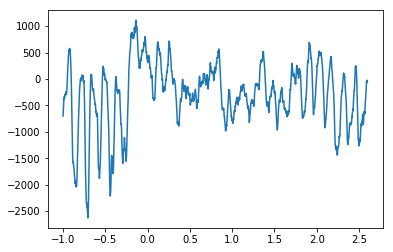

In [153]:
plt.plot(base_eegs['time'],base_eegs[0,0,:]) #plot channel 0 at 0 event

# Let's take advantage of python's object oriented programming and create an object that represents ecog subjects

In [190]:
import pandas as pd
import xarray as xr
import numpy as np
import os, sys
from glob import glob
# Import ptsa Readers
from ptsa.data.readers import BaseEventReader
from ptsa.data.readers.IndexReader import JsonIndexReader
from ptsa.data.filters import MonopolarToBipolarMapper
from ptsa.data.filters import ButterworthFilter
from ptsa.data.filters.MorletWaveletFilter import MorletWaveletFilter
from time import time
from scipy.stats.mstats import zscore

class Subject:
    """
    A class Logan will use to initialize inputted data
    """
    
    def __init__(self, subj, exp, json=True):
        self.subj = subj
        self.exp = exp
        self.json = json
        if self.json is True:
            if 'RAM_' in self.exp:
                self.exp = self.exp.split('RAM_')[-1]
        # Don't get any bad tals
        self.mp, self.bp, self.tal, self.coords = self.get_good_trodes(self.subj)
        # Load events and initial mp eegs
        self.events, self.eegs = self.init_setup(self.mp)
        # Make eeg bipolar, filter noise
        self.eegs = self.get_filtered_bp_eegs()
        
    def init_setup(self, mp):
        """
        A function that will initialize relevant variables to begin the analysis on.

        Parameters:

            Inputs: mp: monopolar electrodes
                    
                    If not in a class can use: 
                    subj: string id of a subject, e.g. 'R1111M'
                    experiment: string id of the experiment, e.g. 'pyFR', 'RAM_FR1/'
                    instead of self 

            Possible Outputs:
                    subject: string id of a subject, e.g. 'R1111M'
                    exp: string id of the experiment, e.g. 'pyFR', 'RAM_FR1/'
                    e_path: path to events
                    tal_path: path to talirach structures
                    tal_structs: np.array of talirach structures for subject
                    monopolar_channels: list of monopolarchannels ***DO NOT USE*** > We will use nora's way instead
                    bipolar_pairs: list of bipolar_pairs ***DO NOT USE*** > We will use nora's way instead
                    base_events: array containing information to behavioral events
                    base_eegs: array containing BAD bipolar_pairs, base_events, and an array of eeg activity
        Note:
            mp,bp channels, tal_structs and base_eegs ALL could be contaminated by bad electrode channels,
            for the initial set-up it doesn't matter, since base_eegs is only loaded here for debugging,
            all real analysis loads in the PROPER eeg, with only the non-contaminated channels.
        """
        try: 
            #---------------------> Initial set-up + define paths
            subject = self.subj
            exp = self.exp
            e_path = os.path.join('/data/events/', exp, subject + '_events.mat')
            tal_path = os.path.join('/data/eeg/', subject, 'tal', subject + '_talLocs_database_bipol.mat')

        except:
            print 'Error in initial set up [e.g. e_path, tal_path]', subject, exp

        try:
            # ------------------- READING TAL STRUCTS + MP/BP Pairs
            tal_reader = TalReader(filename=tal_path)
            tal_structs = tal_reader.read()
            monopolar_channels = tal_reader.get_monopolar_channels()
            bipolar_pairs = tal_reader.get_bipolar_pairs()
        except:
            print 'Error reading tal structs', subject, exp

        try:
            # ------------------- READING BEHAVIORAL EVENTS
            if self.json is True:
                base_events = self.get_json_events(self.subj, self.exp)
            if self.json is False:
                base_e_reader = BaseEventReader(filename=e_path, eliminate_events_with_no_eeg=True)
                base_events = base_e_reader.read()
        except:
            print 'Error reading base_events', subject, exp

        try:
            #-------------------- READING EEG FILES
            eeg_reader = EEGReader(events=base_events, channels=mp,
                                   start_time=-2.0, end_time=0., buffer_time=1.0)
            base_eegs = eeg_reader.read()

            return base_events, base_eegs

        except:
            print 'Error reading base_eegs', subject, exp
            
    @staticmethod            
    def get_json_subjs(exp):
        """
        Get subject ids using jsonIndexReader

        -----
        INPUTS:
        exp: the name of the experiment get subjects for
        -----
        OUTPUTS:
        subjs: a list of subjects for the experiment
        """
        from ptsa.data.readers.IndexReader import JsonIndexReader
        jr = JsonIndexReader('/protocols/r1.json')
        subjs = jr.subjects(experiment=exp)
        return subjs

    @staticmethod
    def get_json_info(subj):
        """
        Returns a dictionary of the number of sessions of data
        each subject has for a given experiment, as well as 
        the montage number per session (this may be the same value)
        ------
        INPUTS:
        subj: a string or unicode of a valid subject_id gotten
        ------
        OUTPUTS:
        exp_d: a dictionary of how many sessions a subject has per exp
        montages_d: a dictionary of the montage per exp.
        """
        from ptsa.data.readers.IndexReader import JsonIndexReader
        jr = JsonIndexReader('/protocols/r1.json')
        # Get a dictionary of how many sessions are in each exp 
        # the subj has
        exp_d = {exp: jr.sessions(subject=subj,experiment=exp
                             ) for exp in jr.experiments(subject=subj)}
        # Get electrode montage number for the subj per exp
        montages_d = {exp: jr.montages(subject=subj,experiment=exp
                         ) for exp in jr.experiments(subject=subj)}
        return exp_d, montages_d
    
    @staticmethod
    def get_json_events(subj, exp, pandas=False):
        """
        loads subjects events using the json method and return out
        their behavioral events as pandas dataframe (pandas=True),
        numpy recarray (recarray=True) or both

        INPUTS:
        subj: a string or unicode of a valid subject_id 
        exp: the name of the experiment get subjects for
        ------
        OUTPUTS:
        events: np.recarray, behavioral events for subj
        events_df: pd.DataFrame, behavioral events for subj
        """
        from ptsa.data.readers.IndexReader import JsonIndexReader
        from ptsa.data.readers import BaseEventReader
        import numpy as np
        if pandas is True:
            import pandas as pd
        jr = JsonIndexReader('/protocols/r1.json')
        events = np.concatenate([BaseEventReader(filename=f).read() for f in
                                 jr.aggregate_values('task_events',
                                                     subject=subj,
                                                     experiment=exp)]
                            )
    
        # Because np.concatenate turns record arrays into structured arrays, 
        # and attribute-like field access is nice
        events = np.array(events).view(np.recarray)
        if pandas is False: return events
        events_df = pd.DataFrame.from_records([event for event in events],
                                           columns = events.dtype.names)
        return events, events_df

    @staticmethod        
    def get_good_trodes(subjects):
        """
        The code below was created by Nora and will go through and read the text files
        good_leads and bad_leads in order to ensure that only good electrodes are read

        Parameters:

        Input:
            subjects: string ID of a subject (e.g. 'R1111M')

        Outputs:
            mpChans: identical to mp gotten other way, except excludes bad chs
            bpChans: identical to bp gotten other way, except excludes bad chs
        """

        #This looks wonky so it can easily be changed to run multiple subjects or a single subject as below
        talPath = []
        #Go through subjects, or here one subject and get tal paths
        for i,j in enumerate(subjects):
            subject = subjects
            tal_path = os.path.join('/data/eeg/', subject, 'tal', subject + '_talLocs_database_bipol.mat')
            talPath.append(tal_path)
        #get mp/bp channels
        monopolar_channels = [
            tal_readeri.get_monopolar_channels() for tal_readeri in [
                TalReader(filename=talPathi) for talPathi in talPath]] 
        bipolar_pairs      = [
            tal_readeri.get_bipolar_pairs() for tal_readeri in [
                TalReader(filename=talPathi) for talPathi in talPath]]

        # Exclude bad channels
        bpPairs = []
        mpChans = []
        countt = 0
        for talPathi, bipolar_pairsi, monopolar_channelsi in zip(talPath, bipolar_pairs, monopolar_channels):
            try:#Read text files, only get channels that are good
                goodleads     = open(os.path.dirname(talPathi)+'/good_leads.txt','r').read()
                goodleads_1st = open(os.path.dirname(talPathi)+'/good_leads.txt','r').readline(1)
                subPairs = np.array(
                    [pairi for pairi in bipolar_pairsi if (
                            '\n' + pairi[0].strip('0') + '\n' in goodleads or pairi[0].strip('0') == goodleads_1st) 
                     and ('\n' + pairi[1].strip('0') + '\n' in goodleads or pairi[1].strip('0') == goodleads_1st)])
                subPairs = np.rec.array(subPairs) 
                subChans = np.array(
                    [chani for chani in monopolar_channelsi if '\n' + chani.strip('0') + '\n' in goodleads 
                     or chani.strip('0') == goodleads_1st])
                bpPairs.append(subPairs)
                mpChans.append(subChans)
                countt +=1 
            except:
                print 'failed to do analyze', countt
        bp=bpPairs[0] #wonky for reasons stated above
        mp=mpChans[0]
        tal_reader = TalReader(filename=tal_path)
        tal_structs = tal_reader.read()
            
        """Get only good pairs; int conversion necessary to convert [001,002] 
        into [1,2] for comparasion match"""
        good_pairs=np.array([np.array([(int(x)) for i,x in enumerate(jj)]
        ) for ii,jj in enumerate(bp)])

        # Get indx of good tals
        channels_indx=[]
        for i,ch in enumerate(tal_structs.channel):
            for x,pair in enumerate(good_pairs):
                if (pair[0] in ch) & (pair[1] in ch):
                    channels_indx.append(i)

        # Get good tals from all tals using index
        good_tal=np.array([tal for indx,tal in enumerate(tal_structs) if indx 
                           in channels_indx]).view(np.recarray)
        # Get coords
        if len(good_tal)==len(bp):
            tal = good_tal
            if (('avgSurf' in good_tal.dtype.names)== True) and (
                    'x_snap' in good_tal.avgSurf.dtype.names)== True:
                x = good_tal.avgSurf.x_snap
                y = good_tal.avgSurf.y_snap
                z = good_tal.avgSurf.z_snap
            else:
                if ('x' in good_tal.dtype.names)== True:
                    print 'no avg tals sadface'
                    x,y,z=good_tal.x,good_tal.y,good_tal.z
        coords = zip(x,y,z)
        return mp, bp, tal, coords
    
    @staticmethod
    def get_matlab_subjs(exp):
        """
        -----
        INPUTS:
        exp: the name of the experiment get subjects for
        -----
        OUTPUTS:
        matlab_dict: a dictionary that associates subjects
        in the filed (keys) with paths to their beh data
        (values)
        """
        paths = glob('/data/events/'+exp+'/*_events.mat')
        subjs = [d.split('/')[-1].split('_ev')[0] for d in paths]
        matlab_dict = dict((zip(sorted(subjs),sorted(paths))))
        return matlab_dict
    
    @staticmethod
    def get_matlab_events(path, exp=None,subj=None, pandas=False):
        """
        loads subjects events using the matlab events and return out
        their behavioral events as pandas dataframe (pandas=True),
        numpy recarray (recarray=True) or both

        INPUTS:
        subj: a string or unicode of a valid subject_id
        exp: the name of the experiment get subjects for
                ***RAM should be added to the front of any
                RAM experiment e.g. FR1 > RAM_FR1
        ------
        OUTPUTS:
        events: np.recarray, behavioral events for subj
        events_df: pd.DataFrame, behavioral events for subj
        """

        from ptsa.data.readers import BaseEventReader
        import numpy as np
        if pandas is True:
            import pandas as pd
        try:
            events = BaseEventReader(filename=path).read()
        except:
            if (exp is not None and subj is not None):
                path = '/data/events/'+exp+'/'+subj+'_events.mat'
                events = BaseEventReader(filename=path).read()
                events = np.array(events).view(np.recarray)
            pass

        if pandas is False:
            return events
        events_df = pd.DataFrame.from_records([event for event in events],
                                           columns = events.dtype.names)
        return events, events_df
    
    def get_filtered_bp_eegs(self, monopolar_eegs=None, bipolar_pairs=None):
        """
        Here we'll create a bipolar eeg from re-referencing monopolar channels,
        then we'll remove noise from eletrical lining (60Hz in america, 50Hz in
        germany) and return the filtered eeg
        """
        #-------->BP montage using good BP
        if monopolar_eegs is None:
            monopolar_eegs = self.eegs
            bipolar_pairs = self.bp
        m2b = MonopolarToBipolarMapper(time_series=monopolar_eegs, bipolar_pairs=bipolar_pairs)
        bp_eegs = m2b.filter()
        """Remove 58-62 Hz"""
        if 'FR' not in self.subj: # If not European remove 58-62
            b_filter = ButterworthFilter(time_series=bp_eegs, freq_range=[58., 62.], filt_type='stop', order=4)
            bp_eegs_filtered = b_filter.filter()
        if 'FR' in self.subj:# If european remove 48-52
            b_filter = ButterworthFilter(time_series=bp_eegs, freq_range=[48., 52.], filt_type='stop', order=4)
            bp_eegs_filtered = b_filter.filter()
        return bp_eegs_filtered
    
    @staticmethod            
    def morlet(bp_eeg, freqs=[7.,45.,95.], width=4):
        """
        Applies a morlet wavelet convultion on the data (e.g. taking it from information in Volts per time and outputting 
        frequency power [real math component] and phase [imaginary math component]). 
        INPUTS
        bp_eeg: a time_series object, bipolar filtered eeg with butterworthfilter already applied
        freqs: a list of freqs you wish to apply the convultion over, log spacing = a good idea
        width: the amount of wavelets you put in one window, do you want to focus on optimizing lower freq or higher?
        """
        wf = MorletWaveletFilter(time_series=bp_eeg,
                                      freqs=np.array(freqs), width=width,
                                      #output='power', #This can be either power, phase, or empty and retrun both
                                      #output: return np.abs(wavelet_coef_array) ** 2, None
                                     )

        pow_wavelet, phase_wavelet = wf.filter()

        #Remove the buffer space
        pow_wavelet = pow_wavelet.remove_buffer(duration=1.0)

        #Log transform the data due to power lower scaling of neuronal data
        np.log10(pow_wavelet.data, out=pow_wavelet.data);
        
        return pow_wavelet, phase_wavelet

# Let's create a subject instace representing R1111M in experiment FR1/ RAM_FR1

In [147]:
subj_j=Subject('R1111M', exp='RAM_FR1',json=True)

<xarray.TimeSeriesX (bipolar_pairs: 141, events: 2370, time: 2000)>
array([[[  7102.304268,   7089.502138, ...,   7101.673896,   7094.405625],
        [  7066.944676,   7072.856936, ...,   7106.850104,   7106.737701],
        ..., 
        [  7195.510045,   7225.407099, ...,   7021.848439,   6985.189458],
        [  7287.738681,   7262.602504, ...,   7228.24488 ,   7259.303318]],

       [[  6287.439962,   6280.323696, ...,   6139.926896,   6132.766256],
        [  6202.509637,   6204.389122, ...,   6312.205483,   6316.396022],
        ..., 
        [  6308.154227,   6340.931589, ...,   6037.075883,   6006.968898],
        [  6427.585485,   6406.071615, ...,   6322.814153,   6355.387254]],

       ..., 
       [[-10350.625213, -10348.691005, ..., -10268.971522, -10267.559849],
        [-10334.424802, -10333.541955, ..., -10254.751346, -10256.619473],
        ..., 
        [-10186.94168 , -10187.520007, ..., -10229.303455, -10231.11776 ],
        [-10196.749139, -10195.465331, ..., -102

# Let's do a morlet wavelet convultion, taking 20 wavelets log spaced from 2 to 95 on the first sessions's recalled words

In [154]:
freqs = np.logspace(np.log10(2), np.log10(95), 20).tolist()
freqs

[2.0,
 2.4506259485797033,
 3.002783769926086,
 3.6793499122774254,
 4.508355184465758,
 5.524146100232811,
 6.768807888487952,
 8.293908126239785,
 10.162633234649642,
 12.45240635536545,
 15.258095068358694,
 18.695941850207902,
 22.90838011562836,
 28.069935375643087,
 34.39445600325316,
 42.14397318442758,
 51.63955713100272,
 63.27461933919967,
 77.53121201957293,
 95.00000000000001]

In [167]:
# Transpose so we can manipulate events with boolean indexing
eeg = subj_j.eegs.transpose('events', 'bipolar_pairs','time')
recs = eeg[(eeg.events.data['type']=='REC_WORD')
              &(eeg.events.data['session']==1)]
recs

<xarray.TimeSeriesX (events: 101, bipolar_pairs: 141, time: 2000)>
array([[[  7313.775107,   7333.464092, ...,   7111.355623,   7102.648874],
        [  6209.859461,   6219.675108, ...,   6078.403581,   6074.277993],
        ..., 
        [-10185.156249, -10194.140769, ..., -10153.930259, -10153.848202],
        [ -1433.907506,  -1433.107803, ...,  -1442.595112,  -1441.40492 ]],

       [[  7272.437769,   7259.135881, ...,   7186.836295,   7197.134903],
        [  6195.191184,   6177.793248, ...,   6009.323003,   6011.80853 ],
        ..., 
        [-10227.134666, -10225.450362, ..., -10206.333314, -10218.738838],
        [ -1492.327399,  -1492.207169, ...,  -1462.14306 ,  -1460.823759]],

       ..., 
       [[  7108.765574,   7099.200069, ...,   7183.2535  ,   7176.368883],
        [  6193.257068,   6187.571414, ...,   6106.345472,   6104.567339],
        ..., 
        [-10204.561808, -10207.721477, ..., -10290.275212, -10288.929375],
        [ -1470.838299,  -1464.763177, ...,  -139

In [172]:
power, phase = Subject.morlet(recs, freqs=freqs, width=7)

('total time wavelet loop: ', 52.740407943725586)


In [213]:
power # Rembmer to z-score each session independently...

<xarray.TimeSeriesX (frequency: 20, events: 101, bipolar_pairs: 141, time: 1000)>
array([[[[ 9.785838, ...,  9.452131],
         ..., 
         [ 7.950558, ...,  8.106256]],

        ..., 
        [[ 9.266674, ...,  9.383155],
         ..., 
         [ 8.122102, ...,  8.567571]]],


       ..., 
       [[[ 3.891898, ...,  3.105967],
         ..., 
         [ 3.568938, ...,  3.397681]],

        ..., 
        [[ 4.590017, ...,  4.47822 ],
         ..., 
         [ 3.224568, ...,  2.658465]]]], dtype=float32)
Coordinates:
  * bipolar_pairs  (bipolar_pairs) (numpy.record, [('ch0', 'S3'), ('ch1', 'S3')]) ('001', '002') ...
  * frequency      (frequency) float64 2.0 2.451 3.003 3.679 4.508 5.524 ...
  * events         (events) (numpy.record, [('session', '<i8'), ('eegoffset', '<i8'), ('protocol', 'S256'), ('intrusion', '<i8'), ('item_name', 'S256'), ('serialpos', '<i8'), ('rectime', '<i8'), ('stim_params', '<f8', (0,)), ('list', '<i8'), ('subject', 'S256'), ('eegfile', 'S256'), ('montage', 

### RAM Computational Pipeline
This tutorial demonstrates how to build Logistic Regression Classifier of Good memory for a single patient in 30 lines of code. The code is based on the refactored PTSA toolkit that uses xarray as a core container for the time series data. To construct classifier we will need two classes of objects:


Readers

Filters

Readers are objects that read data store on the hard drive. For the purpose of building memory classifiers we need the following readers:

BaseEventReader - an object that reads so called events files (stored in Matlab format)

TalReader - an object that reads the so called "Tal Structs" i.e. the information about pairing of bipolar electrodes, location of electrods specified in various coordinates systems and name of the brain areas where electrodes are placed.

EEGReader - and object that reads raw EEG for specified events and electrodes

We will use 3 filter objects:

MonopolarToBipolarFilter - an onbject that takes as an input monopolar time series (as returned by EEGReader) and returns another time series where for each bipolar pair we form a series that is difference of two monopolar time series as specified as given by the bipolar pair specification. For example, we may have 100 monopolar electrodes but the number of bipolar pairs wcould be 125 or so. MonopolarToBipolarFilter will transform an input time series corresponding witj monopolar data to the one corresponding to bipolar data

ButterworthFiler - an object that applies Butterworth filter along time axis of the series. For example our time series can be represented by a 3-dimensional array with dimensions "bipolar_pairs", "events" and "time"and in this case ButterworthFilter will do filtering along "time" dimension

MorletWaveletFilter - an object that takes as an input a time series, applies continuous wavelet convolution along time axis and returns another time series of wavelet coeeficients (represented as power and phase arrays). For example our time series can be represented by a 3-dimensional array with dimensions "bipolar_pairs", "events" and "time" and in this case MoreletWaveletFilter would return 4-dimensional array of wavelet coeeficients (power, phase) with dimensions being frequency, "bipolar_pairs", "events" and "time", where frequency is center wavelet frequency.

First let us start by importing modules/classes that we will need in our computational pipeline:

In [1]:
import sys
import numpy.testing 
import numpy as np
from ptsa.data.readers import BaseEventReader
from ptsa.data.readers.TalReader import TalReader
from ptsa.data.readers import EEGReader
from ptsa.data.filters import MonopolarToBipolarMapper
from ptsa.data.filters import ButterworthFilter
from ptsa.data.filters.MorletWaveletFilter import MorletWaveletFilter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats.mstats import zscore
from time import time
import os
start_time = time()

Could not import MorletWaveletFilterCppLegacy (single-core C++ version of MorletWaveletFilter): cannot import name MorletWaveletTransform
You can still use MorletWaveletFilter


In [2]:
subject = 'R1111M'
exp = 'RAM_FR1/'
e_path = os.path.join('/data/events/', exp, subject + '_events.mat')
tal_path = os.path.join('/data/eeg/', subject, 'tal', subject + '_talLocs_database_bipol.mat')
# ------------------- READING TAL STRUCTS
tal_reader = TalReader(filename=tal_path)
monopolar_channels = tal_reader.get_monopolar_channels()
bipolar_pairs = tal_reader.get_bipolar_pairs()
# ------------------- READING EVENTS
base_e_reader = BaseEventReader(filename=e_path, eliminate_events_with_no_eeg=True)
base_events = base_e_reader.read()
base_events = base_events[base_events.type == 'WORD']

After we read events and "tal structs" we are ready to read raw eeg monopolar data. To do that we create an EEGReader object passing the following information as arguments of the constructor:

events - numpy recarray storing the content of events file

channels - numpy array of monopolar channel labels

start_time - an offset expressed in units of seconds that specifies where the read statrts relative the to event position in the eeg file

end_time - an offset expressed in units of seconds that determines where the read ends rrelative the to event position in the eeg file

buffer_time - extra buffer (specified in units of seconds) added before start_time_position and after end_time position

In [3]:
eeg_reader = EEGReader(events=base_events, channels=monopolar_channels,
                       start_time=0.0, end_time=1.6, buffer_time=1.0)

base_eegs = eeg_reader.read()

base_eegs.dtype

dtype('float64')


At this point all the data necessary to construct our memory classifier is loaded into computer memory and we are ready to process it. Since we are interested in looing at potential difference between electrodes we will first need to transform monopolar data to the the one where time series are differences between appropriate monopolar data.It is instructive to look at the raw eeg data. Notice that I shortened the output by using base_eegs[0:2,0:2,0:300]

In [4]:
base_eegs[0:2,0:2,0:300]

<xarray.TimeSeriesX (channels: 2, events: 2, time: 300)>
array([[[ 3467.059196,  3471.312604, ...,  3574.989424,  3576.052776],
        [ 3609.548364,  3609.548364, ...,  3548.405624,  3543.62054 ]],

       [[-3652.082444, -3648.360712, ..., -3497.364728, -3505.339868],
        [-3565.950932, -3568.609312, ..., -3489.389588, -3483.009476]]])
Coordinates:
  * channels    (channels) |S3 '001' '002'
    samplerate  float64 499.7
  * events      (events) (numpy.record, [('subject', '<U256'), ('session', '<i8'), ('list', '<i8'), ('serialpos', '<i8'), ('type', '<U256'), ('item', '<U256'), ('itemno', '<i8'), ('recalled', '<i8'), ('mstime', '<f8'), ('msoffset', '<i8'), ('rectime', '<i8'), ('intrusion', '<i8'), ('isStim', '<i8'), ('expVersion', '<U256'), ('stimLoc', '<U256'), ('stimAmp', '<f8'), ('stimAnode', '<f8'), ('stimAnodeTag', 'S256'), ('stimCathode', '<f8'), ('stimCathodeTag', 'S256'), ('stimList', '<i8'), ('eegfile', '<U256'), ('eegoffset', '<i8')]) (u'R1111M', 0, 1, 1, u'WORD', u'BEA


As we can see raw EEG data (base_eegs) is a 3D array with axes corresponding to channels, events and time. To access a single time seriec for a given channel (say channel 0 where zero refers to index of the channel not its label) and a given event (say 0th event) we would type:

In [5]:
base_eegs[0,0,:]

<xarray.TimeSeriesX (time: 1800)>
array([ 3467.059196,  3471.312604,  3473.970984, ...,  3580.306184,
        3581.901212,  3588.813   ])
Coordinates:
    channels    |S3 '001'
    samplerate  float64 499.7
    events      (numpy.record, [('subject', '<U256'), ('session', '<i8'), ('list', '<i8'), ('serialpos', '<i8'), ('type', '<U256'), ('item', '<U256'), ('itemno', '<i8'), ('recalled', '<i8'), ('mstime', '<f8'), ('msoffset', '<i8'), ('rectime', '<i8'), ('intrusion', '<i8'), ('isStim', '<i8'), ('expVersion', '<U256'), ('stimLoc', '<U256'), ('stimAmp', '<f8'), ('stimAnode', '<f8'), ('stimAnodeTag', 'S256'), ('stimCathode', '<f8'), ('stimCathodeTag', 'S256'), ('stimList', '<i8'), ('eegfile', '<U256'), ('eegoffset', '<i8')]) (u'R1111M', 0, 1, 1, u'WORD', u'BEAR', 17, 1, 1453499295325.0, 1, 5211, -999, 0, u'v_1.05', u'X', -999.0, -999.0, '', -999.0, '', 0, u'/data/eeg/R1111M/eeg.noreref/R1111M_FR1_0_22Jan16_1638', 100521) ...
  * time        (time) float64 -1.0 -0.998 -0.996 -0.994 -0.992 

Let us plot this data. First lets import matplotlib and ensure that ipython notebook can inline the plots

In [6]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

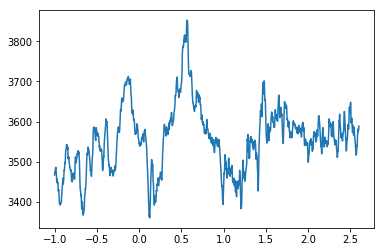

In [7]:
plt.plot(base_eegs['time'],base_eegs[0,0,:]) #plot channel 0 at 0 event

Notice that I refered to a time axis in the eeg data (base_eegs) as base_eegs['time']. Now let's do two other plots one showing raw eeg data for the channel with index 1 (i.e. second monopolar channels - as we start counding from 0 in Python) and another the dirrefence the voltage difference between the two channels

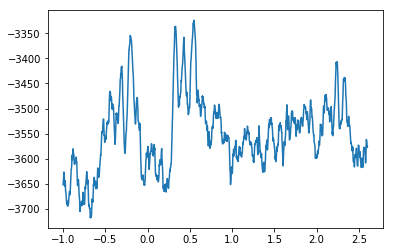

In [8]:
#This is raw eeg data for channel with index 1
plt.plot(base_eegs['time'],base_eegs[1,0,:])

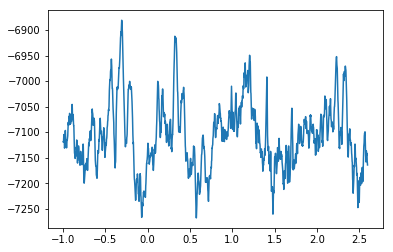

In [9]:
#This is the difference between the two
plt.plot(base_eegs['time'],base_eegs[1,0,:]-base_eegs[0,0,:])

Before applying MonopoarToBipolarFilter lets take a look at the bipolar pairs

In [10]:
#This will list the bipolar pairs
bipolar_pairs[0:3]

rec.array([('001', '002'), ('001', '009'), ('002', '003')], 
          dtype=[('ch0', 'S3'), ('ch1', 'S3')])

and also let us examine monopolar channels:

In [11]:
#This will let us examine monopolar channels
monopolar_channels[0:10]

array(['001', '002', '003', '004', '005', '006', '007', '008', '009', '010'],
      dtype='|S3')

as you can see based onthe specification of the first bipolar pairs for the first pairs we need to subtract values time series of channels with labels '001' and '002', for the second one we subtract time series for channels with labels '001' and '009', etc... We write a loop to do this manually or we can use MonopolarToBipolarMapper that does exactly these operations for us:

In [12]:
m2b = MonopolarToBipolarMapper(time_series=base_eegs, bipolar_pairs=bipolar_pairs)
bp_eegs = m2b.filter()

Let us check if indeed MonopolarToBipolarMapper does what we expect and compare first two bipolar time series reported by the mapper to the values we woudld obtain using manual calculations:

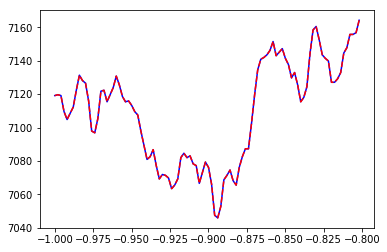

In [13]:
first_bp = bp_eegs[0,0,:]
second_bp = bp_eegs[1,0,:]

first_bp_manual = base_eegs[0,0,:]-base_eegs[1,0,:]
second_bp_manual = base_eegs[0,0,:]-base_eegs[8,0,:]

np.testing.assert_array_equal(first_bp_manual, first_bp)
np.testing.assert_array_equal(second_bp_manual, second_bp)

plt.plot(first_bp['time'][0:100], first_bp[0:100],'b')
plt.plot(first_bp_manual['time'][0:100], first_bp_manual[0:100],'r--')

As you can see the action of the MonopolarToBipolarMapper matches our "manual" computations so at this point we are ready to filter out unwanted frequencies from our bipolar EEG spectrum. We will Apply ButterworthFilter to supporess signal components in the 58 -62 Hz bandwidth:

In [14]:
#Apply ButterworthFilter to remove signal components in 58-62Hz
b_filter = ButterworthFilter(time_series=bp_eegs, freq_range=[58., 62.], filt_type='stop', order=4)
bp_eegs_filtered = b_filter.filter()

Now we are ready to compute wavelet coefficients for our filtered time series of bipolar EEG data. To do that we will use object called MorletWaveltFilter that takes as its constructor parameters time_series object for which we compute wavelets, an array of center wavelet frequencies - freqs (here we are using 8 frequencies that are logaritmically-spacedbetween 3 and 180 Hz) and optional parameter that specifies the return value - here we return power so the output parameter has value 'power' . To allow rudimentary benchmarking of the code we will measure time it takes for the MorletWaveletFilter to carry out its computations. Notice that the filter() function of the MorletWaveletFilter returns two objects - power and phase arrays. Since we are requesting power coeeficients only the phase array will be set to None.

In [15]:
s = time()
wf = MorletWaveletFilter(time_series=bp_eegs_filtered,
                         freqs=np.logspace(np.log10(3), np.log10(180), 8),
                         output='power'                   
                         )

pow_wavelet, phase_wavelet = wf.filter()
print 'TOTAL WAVELET TIME=', time()-s

('total time wavelet loop: ', 225.74857902526855)
TOTAL WAVELET TIME= 225.755007982


Now that we have wavelets computted we will remove buffer to truncate those segments of time series for which wavelet convolution is "contaminated" by so called edge effects. We will also tak logarithm of the powers to handle the fact that spectral powers in the EEG signals show power-law decay with increasing frequencies

In [16]:
pow_wavelet = pow_wavelet.remove_buffer(duration=1.0)
np.log10(pow_wavelet.data, out=pow_wavelet.data);

For the subsequent analysis we will need to reorder the axes of the wavelet power array and compute the mean power across encoding epoch as follows:

In [17]:
pow_wavelet = pow_wavelet.transpose("events","bipolar_pairs","frequency","time")
mean_powers_nd = pow_wavelet.mean(skipna=True,axis=-1)

This is how zscoring works:

In [18]:
a = np.arange(12).reshape(3,4)
print a
a_z = zscore(a, axis=0, ddof=1)
a_z

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]


array([[-1., -1., -1., -1.],
       [ 0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.]])

Once we computed mean powers we are essentially ready to compute classifier, but first we will normalize features (i.e. mean power for each combination of bipolar pair and spectral freqnency) accross the events we will use to train the classifier. As a first step however we will reshape mean_powers_nd array (with dimensions events, bipolar_pair, frequency) to a 2-D array where one axis will correspond to events and the other one will be a Cartesian product of bipolar_pair and frequency axes:

In [19]:
mean_powers_rs = mean_powers_nd.data.reshape(mean_powers_nd.data.shape[0],-1)

first axis of mean_powers_nd corresponds to events and the second one corresponds to Cartesian product (https://en.wikipedia.org/wiki/Cartesian_product) of bipolar_pair and frequency axes of the mean_powers_nd. At this point we are ready to z-score along axis the first axis (axis with index 0 since we number axes starting from 0 in Python) :

In [20]:
zscore_mean_powers = zscore(mean_powers_rs, axis=0, ddof=1)

In [21]:
print zscore_mean_powers

[[-0.06076194  0.19705628 -0.26693964 ...,  0.1783984  -0.21522148
  -1.75154054]
 [-0.32506016 -1.24030828 -0.81009001 ...,  0.10008413  0.32889143
   1.33921826]
 [ 0.42476597  1.20458317  1.62853336 ...,  0.80648041  0.53503162
  -1.52292228]
 ..., 
 [-0.18977417 -0.56269056 -0.97703862 ...,  0.61924982  0.07761019
  -0.62486511]
 [-0.4563522  -0.67742968 -0.38791963 ...,  1.29483616  2.25383759
   0.13245152]
 [-1.8982842  -0.22969365 -1.12123942 ...,  0.50345713  0.66889888
  -1.04355288]]


In [22]:
#check how many FR1 sessions we have in data
np.unique(base_events.session)

array([0, 1, 2, 3])


We have 3 sessions so for the purpose of this tutorial we will use session 0 and 1 as training data and session 2 as a test data Let's first construct mask arrays that we will use to perform selection along axis corresponding to events. in essence the masking or selector array, if you will, is a Boolean array that has number of elements equal to the number of events. So when e.g. 20th element of this array is True and 22nd is False the selection along events axis will pick 20th element but discard 22nd. IN the code below we are constructing selector arrays for training and validation sessions and use this array to select events and zscored powers for training and validation sessions

In [23]:
sess_min = 0
sess_max = 1
validation_sess_min = 2
validation_sess_max = 2

evs = base_events
# ----------------------- computting training and validation session mask arrays to facilitate event selection
training_session_mask =(evs.session>=sess_min) &(evs.session<=sess_max)  
validation_session_mask =(evs.session>=validation_sess_min) &(evs.session<=validation_sess_max)  



# --------------- selecting training events
evs_sel = evs[training_session_mask]
# ---------- converting recalled field of the events into integer array (recalled items are 1's and non-recalled are 0s)
recalls_array = evs_sel.recalled.astype(np.int)
# --------------- selecting zscored powers for training data
training_data = zscore_mean_powers[training_session_mask,...]

# --------------- selecting validation events (out session data)
evs_val = evs[validation_session_mask]
# --------------- selecting zscored powers for out session data
validation_data = zscore_mean_powers[validation_session_mask,...]
# ---------- converting recalled field of the events into integer array for out session data
validation_recalls_array = evs_val.recalled.astype(np.int)


Now, we will construct LogisticRegression object that will fit logistic regression coefficients for classifier features (i.e., zscored mean powers for each combination of bipoar pair and frequency):

In [24]:
lr_classifier = LogisticRegression(C=7.2e-4, penalty='l2', class_weight='balanced', solver='liblinear') #c=7.2e-4
lr_classifier.fit(training_data, recalls_array)

LogisticRegression(C=0.00072, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


Once we have the coeeficients we can calculate AUC for the training data.

In [25]:
recall_prob_array = lr_classifier.predict_proba(training_data)[:,1]
auc = roc_auc_score(recalls_array, recall_prob_array)
print auc

0.832032610968


We can also plot ROC curve (false positives rate (FPR) vs. true positives rate (TPR) ) for in-session (aka training) data

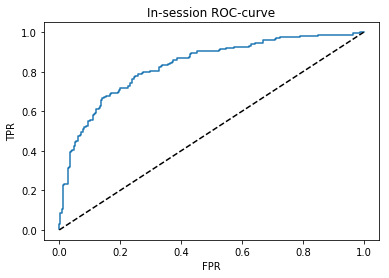

In [26]:
roc_curve_data_in = roc_curve(recalls_array,recall_prob_array)
fpr_in = roc_curve_data_in[0]
tpr_in = roc_curve_data_in[1]
plt.plot(fpr_in,tpr_in)
plt.plot((0.0,1.0),(0.,1.),'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('In-session ROC-curve')


However to asses real value of the classifier wee need to test it on the data differennt than the training data (out-session data). We already have validation dataset solet's use it to compute out-session AUC and ROC curve:

In [29]:
validation_recall_prob_array = lr_classifier.predict_proba(validation_data)[:,1]
validation_auc = roc_auc_score(validation_recalls_array, validation_recall_prob_array)
validation_auc

0.71197572018508382

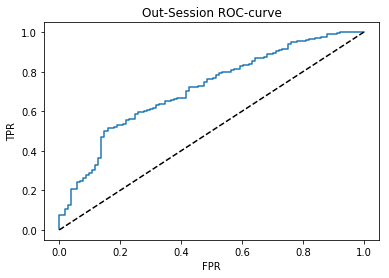

In [30]:
roc_curve_data_out = roc_curve(validation_recalls_array, validation_recall_prob_array)
fpr_out = roc_curve_data_out[0]
tpr_out = roc_curve_data_out[1]
plt.plot(fpr_out,tpr_out)
plt.plot((0.0,1.0),(0.,1.),'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Out-Session ROC-curve')

Notice that in our example we used entire data set (training + x-validation) during z-scoring. In real applications we will have training data set which we will z-score and then then we will compute z-score for the training dataset separately (possibly using variance estimate for the training set). However in order to keep this tutorial relatively simple i made simplifying assumption and zscored entire data set.

In [31]:
time()-start_time

485.79093289375305

For logistic regression classifier we estimate probabilities that a given event belongs to a a class of recalled events. The probability formula is given by:
$P(x)=\left({1+e^{-\left(B+\sum w_i x_i\right)}}\right)^{-1}$
which implies that we are looking for a dividing hyperplane that will separate recalled and non-recalled events. The equation of this hyperplane is simply
$B+\sum w_i x_i = 0$
where $B$ is the intercept and $w_i$'s are weights coefficients fitted by Logistic Regression algorithm. $x_i$'s are features of the classifier - in our case $x_i$'s denote mean powers for the i-th combination of spectral frequency and bipolar pair. While ROC and AUC can give you a sense of classifier performance, sometimes it is nice to be able to visualize how well the dividing hyperplane separates data points belonging to thtw two classes (here recalled vs non recalled) We can do it by projecting N dimensional space into two dimennsions and plot dividing plane as well as individual , color-coded events. Let's rewrite $B+\sum w_i x_i = 0$ as
$ B+X+Y = 0 $ where $X = \sum_{i=0}^{i=200} w_i x_i$ and $Y = \sum_{i=201}^{i=N} w_i x_i$. The number 200 is arbitrary here. The idea is that we can treat a weighted sum of first n features as one variable and the weighted sum of the remaining features as another variable and plot those on a scatter plot. Here I picked $n=200$ and $N$ denotes total number of features. Since $ B+X+Y = 0 $ is the exponent in the logistic probability function the line along which the probability of the data point belonging to either class is exactly 0.5 is called dividing line. It is not hard to see that the equation of hte dividing line is exactly  $ B+X+Y = 0 $ because when the exponent is $0$ then
$P(x)=\left({1+e^{-0}}\right)^{-1}=0.5$
Now, the data points that lie above the dividing line will get assigned high probability (here, of being recalled) and those that lie below will get assigned low probability

In [32]:
w_tmp = np.squeeze(lr_classifier.coef_)

In [33]:
w=np.zeros(len(w_tmp)+1)
w[0]=lr_classifier.intercept_
w[1:]=w_tmp

In [34]:
x_project=np.dot(training_data[:,:200],w[1:201])
y_project=np.dot(training_data[:,200:],w[201:])
recalled_ind = recalls_array==0

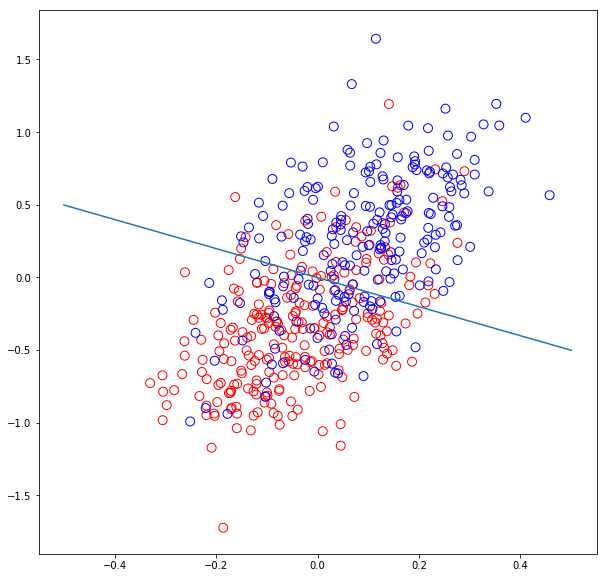

In [35]:
fig = plt.figure(figsize=(10, 10))

# plt.plot(x_line, y_line)
# plt.ylabel('uniform sample')
x = np.linspace(-.5,.5)
plt.plot(x, -w[0]-x)
plt.scatter(x=x_project[recalled_ind], y=y_project[recalled_ind], s=80, facecolors='none', edgecolors='r')
plt.scatter(x=x_project[~recalled_ind], y=y_project[~recalled_ind], s=80, facecolors='none', edgecolors='b')

The analogous plot for the validation data would look as follows

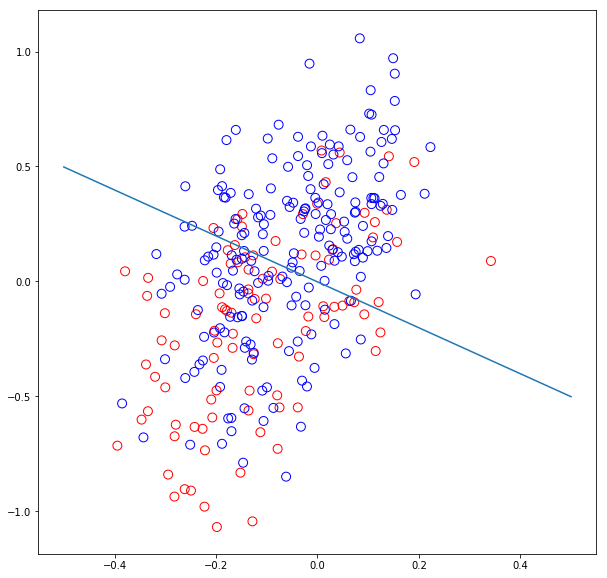

In [36]:
x_project_val=np.dot(validation_data[:,:200],w[1:201])
y_project_val=np.dot(validation_data[:,200:],w[201:])
validation_recalled_ind = validation_recalls_array==0
fig = plt.figure(figsize=(10, 10))

# plt.plot(x_line, y_line)
# plt.ylabel('uniform sample')
x = np.linspace(-.5,.5)
plt.plot(x, -w[0]-x)
plt.scatter(x=x_project_val[validation_recalled_ind], y=y_project_val[validation_recalled_ind], s=80, facecolors='none', edgecolors='r')
plt.scatter(x=x_project_val[~validation_recalled_ind], y=y_project_val[~validation_recalled_ind], s=80, facecolors='none', edgecolors='b')

The syntax for classes may not be very clear at this point, but consider for a moment how you might create a rocket without using classes. You might store the x and y values in a dictionary, but you would have to write a lot of ugly, hard-to-maintain code to manage even a small set of rockets. As more features become incorporated into the Rocket class, you will see how much more efficiently real-world objects can be modeled with classes than they could be using just lists and dictionaries.

Classes in Python 2.7
When you write a class in Python 2.7, you should always include the word object in parentheses when you define the class. This makes sure your Python 2.7 classes act like Python 3 classes, which will be helpful as your projects grow more complicated.

The simple version of the rocket class would look like this in Python 2.7:

In [28]:
class Rocket(object):
    # Rocket simulates a rocket ship for a game,
    #  or a physics simulation.
    
    def __init__(self):
        # Each rocket has an (x,y) position.
        self.x = 0
        self.y = 0

Object-Oriented terminology
Classes are part of a programming paradigm called object-oriented programming. Object-oriented programming, or OOP for short, focuses on building reusable blocks of code called classes. When you want to use a class in one of your programs, you make an object from that class, which is where the phrase "object-oriented" comes from. Python itself is not tied to object-oriented programming, but you will be using objects in most or all of your Python projects. In order to understand classes, you have to understand some of the language that is used in OOP.

General terminology
A class is a body of code that defines the attributes and behaviors required to accurately model something you need for your program. You can model something from the real world, such as a rocket ship or a guitar string, or you can model something from a virtual world such as a rocket in a game, or a set of physical laws for a game engine.

An attribute is a piece of information. In code, an attribute is just a variable that is part of a class.

A behavior is an action that is defined within a class. These are made up of methods, which are just functions that are defined for the class.

An object is a particular instance of a class. An object has a certain set of values for all of the attributes (variables) in the class. You can have as many objects as you want for any one class.

There is much more to know, but these words will help you get started. They will make more sense as you see more examples, and start to use classes on your own.

# TO DO:

Finish porting explaination, spread it to people who may find it handy etc...